To run this python book, one may need to install dependcies like, transformers, seaborn. Also, since the google colab deletes all the files after the runtime is close, one needs to upload the dataset here. It's availble in my github repository.

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

RoBERTa Testing accuracy: 0.9380
RoBERTa Testing F1 score: 0.9332
RoBERTa Testing precision: 0.9454
RoBERTa Testing recall: 0.9213
RoBERTa Testing confusion matrix:
[[505  25]
 [ 37 433]]
RoBERTa Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94       530
           1       0.95      0.92      0.93       470

    accuracy                           0.94      1000
   macro avg       0.94      0.94      0.94      1000
weighted avg       0.94      0.94      0.94      1000



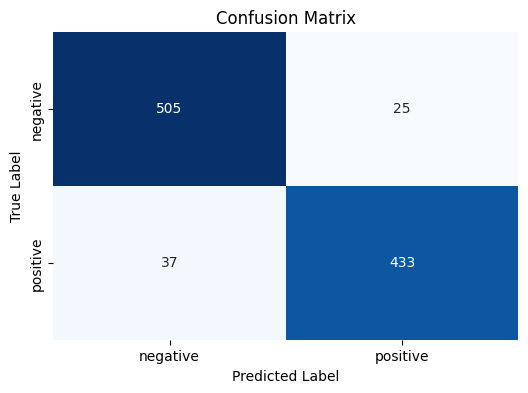

In [8]:
# Import necessary libraries
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizerFast
from transformers import RobertaForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report


# Load dataset
dataset = pd.read_csv('dataset.csv')
# dataset = dataset.head(5000)

dataset['sentiment'] = dataset['sentiment'].map({'positive': 1, 'negative': 0})

# Split data into train and test sets
train_df, test_df = train_test_split(dataset, test_size=0.2, random_state=42)

# Load Roberta tokenizer
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')

# Tokenize input text and create dataset
train_encodings = tokenizer(list(train_df['review']), truncation=True, padding=True)
test_encodings = tokenizer(list(test_df['review']), truncation=True, padding=True)

train_labels = list(train_df['sentiment'])
test_labels = list(test_df['sentiment'])

train_dataset = TensorDataset(torch.tensor(train_encodings['input_ids']),
                              torch.tensor(train_encodings['attention_mask']),
                              torch.tensor(train_labels))

test_dataset = TensorDataset(torch.tensor(test_encodings['input_ids']),
                             torch.tensor(test_encodings['attention_mask']),
                             torch.tensor(test_labels))

# Load Roberta model and set up training parameters
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Train model
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
epochs = 5
for epoch in range(epochs):
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        loss.backward()
        optimizer.step()

# Evaluate model on test set and calculate F1 score
y_true = []
y_pred = []

for batch in test_loader:
    input_ids, attention_mask, labels = batch
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs[0]

    y_true.extend(labels.tolist())
    y_pred.extend(torch.argmax(logits, axis=1).tolist())


y_test = y_true 
y_pred_test = y_pred

accuracy_test = accuracy_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test, pos_label=1)
precision_test = precision_score(y_test, y_pred_test, pos_label=1)
recall_test = recall_score(y_test, y_pred_test, pos_label=1)
confusion_test = confusion_matrix(y_test, y_pred_test)
classification_report_test = classification_report(y_test, y_pred_test)



print(f'RoBERTa Testing accuracy: {accuracy_test:.4f}')
print(f'RoBERTa Testing F1 score: {f1_test:.4f}')
print(f'RoBERTa Testing precision: {precision_test:.4f}')
print(f'RoBERTa Testing recall: {recall_test:.4f}')
print(f'RoBERTa Testing confusion matrix:\n{confusion_test}')
print('RoBERTa Classification Report:\n', classification_report_test)


# Plot confusion matrix
fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(confusion_test, annot=True, fmt='g', cmap='Blues', cbar=False,
            xticklabels=['negative', 'positive'], yticklabels=['negative', 'positive'])
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
plt.show()
